In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import datetime

# Загрузка данных

In [2]:
data = pd.read_csv("iris.csv")

features = data.drop(['species'], axis=1)
target = data['species']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=24)

# Алгоритм

In [3]:
class KNN:
    def __init__(self, k=1):
        self.y_train = None
        self.X_train = None
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train, self.y_train = np.array(X_train), np.array(y_train)

    def euclidean_distances(self, x_test_i):
        return np.sqrt(np.sum((self.X_train - x_test_i) ** 2, axis=1))

    @staticmethod
    def kernel(r):
        return (2 * np.pi) ** (-0.5) * np.exp(-0.5 * r ** 2)

    def _make_prediction(self, x_test_i):
        distances = self.euclidean_distances(x_test_i)

        weights = {}

        for _ in range(len(self.X_train)):
            cl = self.y_train[_]
            index_k_plus_1 = np.argsort(distances)[:self.k+1][-1]

            r = distances[_] / (distances[index_k_plus_1] + 10**(-4))

            try:
                weights[cl] += self.kernel(r)
            except KeyError:
                weights[cl] = self.kernel(r)

        max_ = 0
        max_key = 0
        for key, value in weights.items():
            if value > max_:
                max_key = key
                max_ = value

        return max_key

    def predict(self, X_test):
        return pd.Series([self._make_prediction(x) for x in np.array(X_test)])

In [4]:
class LOO:
    def __init__(self, model_, k):
        self.best_param_ = None
        self.model = model_
        self.k = k
        self.sum_s = {}


    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        for k_ in range(self.k):
            self.model.k = k_
            sum_ = 0

            for _ in range(len(X_train)):
                x_array = X_train[_]
                x_test = pd.DataFrame({'0': [x_array[0]], '1': [x_array[1]], '2': [x_array[2]], '3': [x_array[3]]})

                y_test = y_train[_]

                X_train_ = np.concatenate([X_train[0:_], X_train[_+1:]])
                y_train_ = np.concatenate([y_train[0:_], y_train[_+1:]])

                self.model.fit(X_train_, y_train_)
                pred = self.model.predict(x_test)

                if pd.Series(y_test)[0] != pred[0]:
                    sum_ += 1

            self.sum_s[k_] = sum_ / len(X_train)

        min_ = 10 ** 9
        min_key = 0
        for key, value in self.sum_s.items():
            if value <= min_:
                min_key = key
                min_ = value

        self.best_param_ = min_key

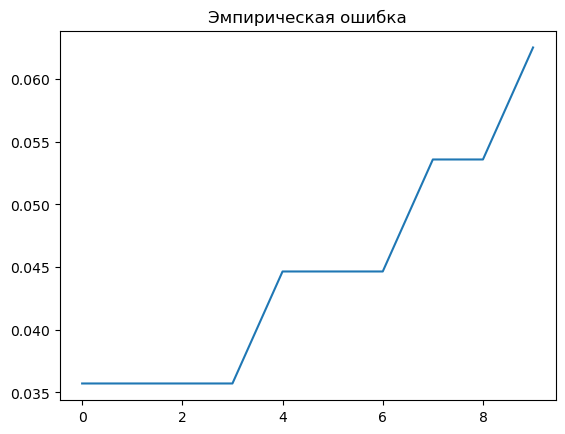

In [27]:
time_ = datetime.datetime.now()
search_params = LOO(model_=KNN(), k=10)
search_params.fit(features_train, target_train)

model = KNN(search_params.best_param_)
model.fit(features_train, target_train)
target_pred = model.predict(features_test)
time__ = datetime.datetime.now()
time_hand = time__ - time_

graph = search_params.sum_s.values()
plt.plot([_ for _ in range(10)], graph)
plt.title('Эмпирическая ошибка')
plt.show()

In [21]:
time_ = datetime.datetime.now()
clf = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': range(1, 10)})
clf.fit(features_train, target_train)

best_model = KNeighborsClassifier(**clf.best_params_)
best_model.fit(features_train, target_train)
predicted = best_model.predict(features_test)
time__ = datetime.datetime.now()
time_lib = time__ - time_

In [26]:
print(f'Время работы билиотечного алгоритма составило {time_lib.microseconds} микросекунд.')
print(f'Время работы написанного алгоритма составило {time_hand.microseconds} микросекунд.')

Время работы билиотечного алгоритма составило 454806 микросекунд.
Время работы написанного алгоритма составило 105637 микросекунд.


In [30]:
compare_df = pd.DataFrame({'y_pred': list(target_pred), 'y_targ': list(target_test)})

acc = len(compare_df.loc[compare_df['y_targ'] == compare_df['y_pred']]) / len(compare_df)
print(f'Accuracy для ручного алгоритма: {acc * 100}')

TP = []
FP = []
FN = []
TN = []

for metric in ['virginica', 'versicolor', 'setosa']:
    TP.append(len(compare_df.loc[(compare_df['y_targ'] == metric) & (compare_df['y_pred'] == metric)]))
    FP.append(len(compare_df.loc[(compare_df['y_targ'] == metric) & (compare_df['y_pred'] != metric)]))
    FN.append(len(compare_df.loc[(compare_df['y_targ'] != metric) & (compare_df['y_pred'] == metric)]))
    TN.append(len(compare_df.loc[(compare_df['y_targ'] != metric) & (compare_df['y_pred'] != metric)]))

TP = np.array(TP)
FP = np.array(FP)
FN = np.array(FN)
TN = np.array(TN)

prec = TP / (TP + FP)
print(f'Precession для ручного алгоритма: {sum(prec) / len(prec) * 100}')

rec = TP / (TP + FN)
print(f'Recall для ручного алгоритма: {sum(rec) / len(rec) * 100}')

print(f'F1 для ручного алгоритма: {sum(2 * (prec * rec) / (prec + rec)) / len(2 * (prec * rec) / (prec + rec)) * 100}')

Accuracy для ручного алгоритма: 97.36842105263158
Precession для ручного алгоритма: 95.83333333333334
Recall для ручного алгоритма: 98.24561403508771
F1 для ручного алгоритма: 96.87687687687688


In [31]:
compare_df = pd.DataFrame({'y_pred': list(predicted), 'y_targ': list(target_test)})

acc = len(compare_df.loc[compare_df['y_targ'] == compare_df['y_pred']]) / len(compare_df)
print(f'Accuracy для ручного алгоритма: {acc * 100}')

TP = []
FP = []
FN = []
TN = []

for metric in ['virginica', 'versicolor', 'setosa']:
    TP.append(len(compare_df.loc[(compare_df['y_targ'] == metric) & (compare_df['y_pred'] == metric)]))
    FP.append(len(compare_df.loc[(compare_df['y_targ'] == metric) & (compare_df['y_pred'] != metric)]))
    FN.append(len(compare_df.loc[(compare_df['y_targ'] != metric) & (compare_df['y_pred'] == metric)]))
    TN.append(len(compare_df.loc[(compare_df['y_targ'] != metric) & (compare_df['y_pred'] != metric)]))

TP = np.array(TP)
FP = np.array(FP)
FN = np.array(FN)
TN = np.array(TN)

prec = TP / (TP + FP)
print(f'Precession для ручного алгоритма: {sum(prec) / len(prec) * 100}')

rec = TP / (TP + FN)
print(f'Recall для ручного алгоритма: {sum(rec) / len(rec) * 100}')

print(f'F1 для ручного алгоритма: {sum(2 * (prec * rec) / (prec + rec)) / len(2 * (prec * rec) / (prec + rec)) * 100}')

Accuracy для ручного алгоритма: 97.36842105263158
Precession для ручного алгоритма: 95.83333333333334
Recall для ручного алгоритма: 98.24561403508771
F1 для ручного алгоритма: 96.87687687687688
